<a href="https://colab.research.google.com/github/cxbxmxcx/Practical_AI_on_GCP/blob/master/Chapter_5_Transformer_Chatbot_save.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup, be sure runtime is set to GPU

In [ ]:
!pip install h5py pyyaml

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.random.set_seed(1234)

!pip install tensorflow-datasets
import tensorflow_datasets as tfds

import os
import re
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin=
    'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,
                                           'movie_conversations.txt')

In [ ]:
MAX_SAMPLES = 50000

def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()  
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)  
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()  
  return sentence

def load_conversations():  
  id2line = {}
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')    
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
    for i in range(len(conversation) - 1):
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
      if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs
  return inputs, outputs

questions, answers = load_conversations()

print('Sample question: {}'.format(questions[75]))
print('Sample answer: {}'.format(answers[75]))

Sample question: bianca , i need to talk to you i need to tell you
Sample answer: i really don t think i need any social advice from you right now .


In [ ]:
import pickle

tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

with open('/content/drive/My Drive/training_tt/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2

print(START_TOKEN, END_TOKEN)
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(questions)))
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[75])))

[8331] [8332]
Vocab size: 8333
Number of samples: 50000
Tokenized sample question: [5374, 3, 4, 137, 9, 182, 9, 5, 4, 137, 9, 87, 29]


In [ ]:
MAX_LENGTH = 40

def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):    
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN    
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
   
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')  
  return tokenized_inputs, tokenized_outputs

questions, answers = tokenize_and_filter(questions, answers)

In [ ]:
print(answers[:-1][0])

[8331   72    3    4  180   18   56  365   40 1086 1692 4214  825    3
   53   15    8 1116   40   29    1 8332    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

Understanding Attention

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

Masking and the Transformer


In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)  
  return mask[:, tf.newaxis, tf.newaxis, :]

print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [ ]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


Positional encoding

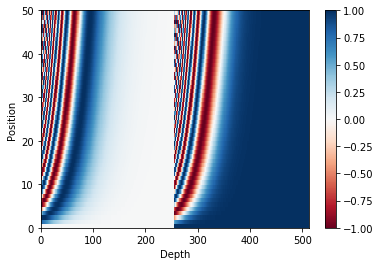

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

Encoding and Decoding the Sequnece

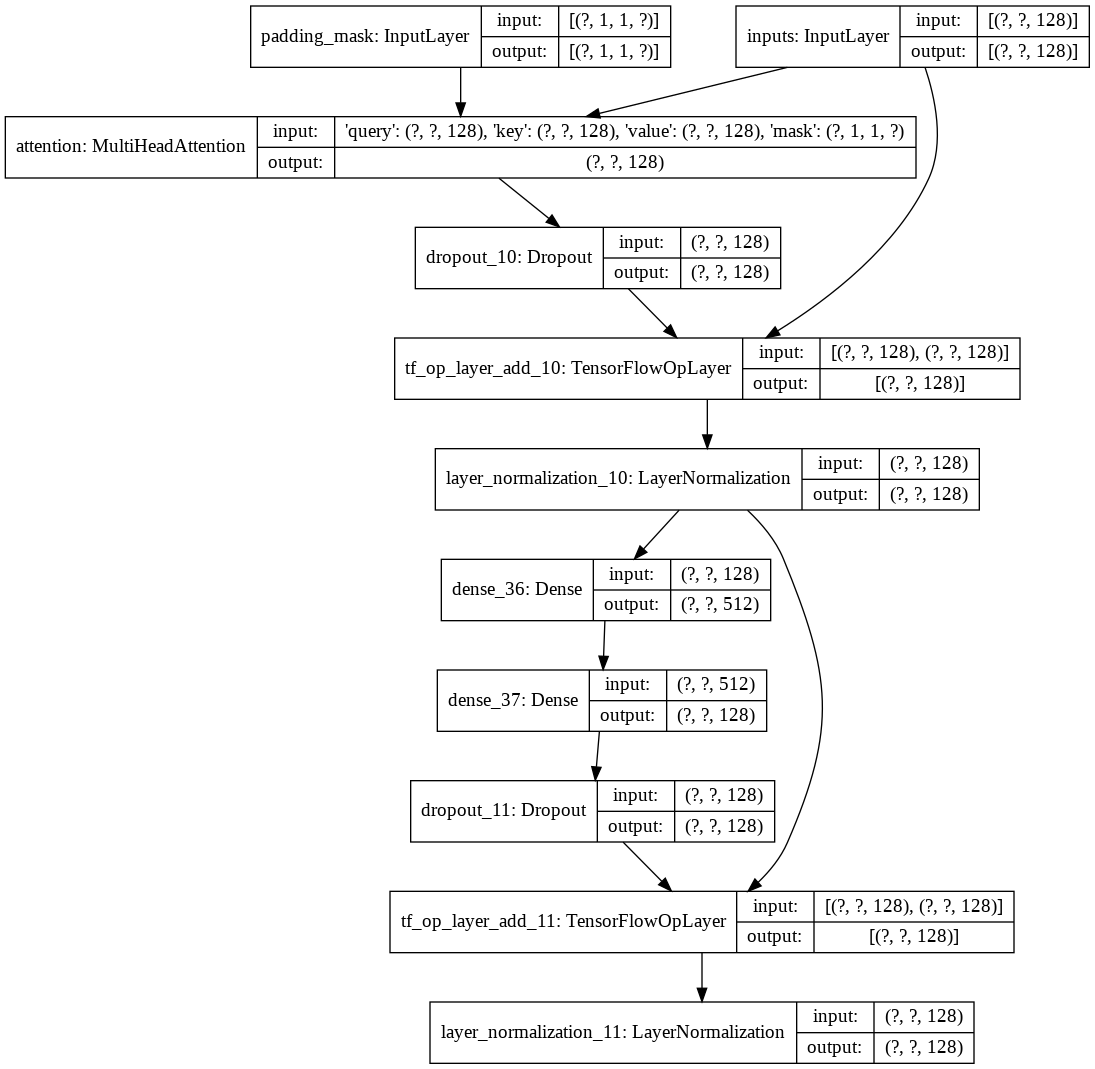

In [ ]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
  
sample_encoder_layer = encoder_layer(
  units=512,
  d_model=128,
  num_heads=4,
  dropout=0.3,
  name="sample_encoder_layer")

tf.keras.utils.plot_model(
    sample_encoder_layer, to_file='encoder_layer.png', show_shapes=True)

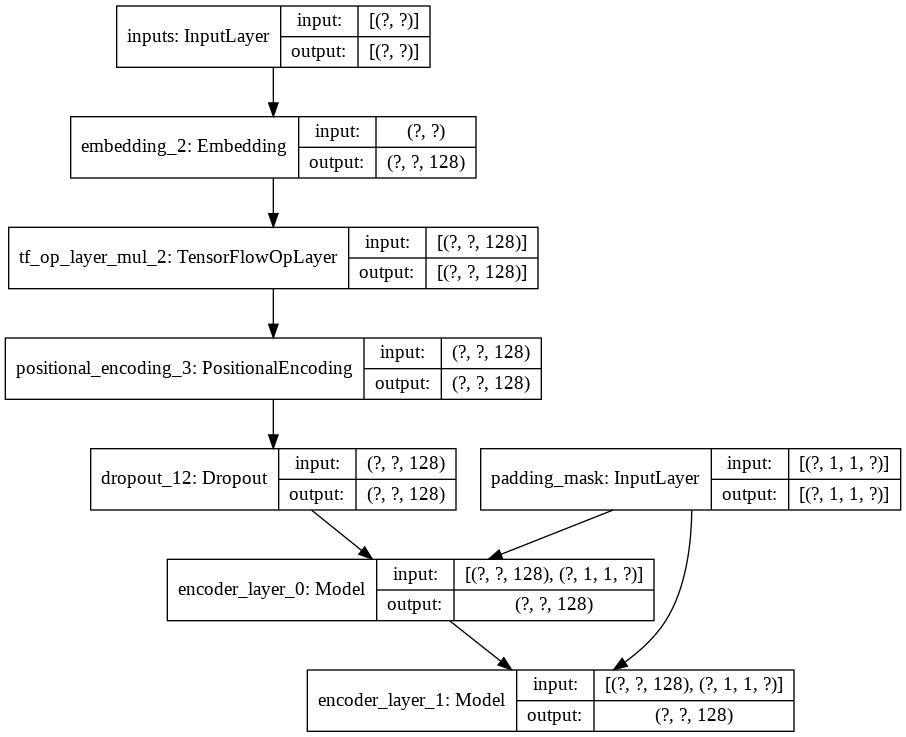

In [ ]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
  
sample_encoder = encoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder")

tf.keras.utils.plot_model(
   sample_encoder, to_file='encoder.png', show_shapes=True)

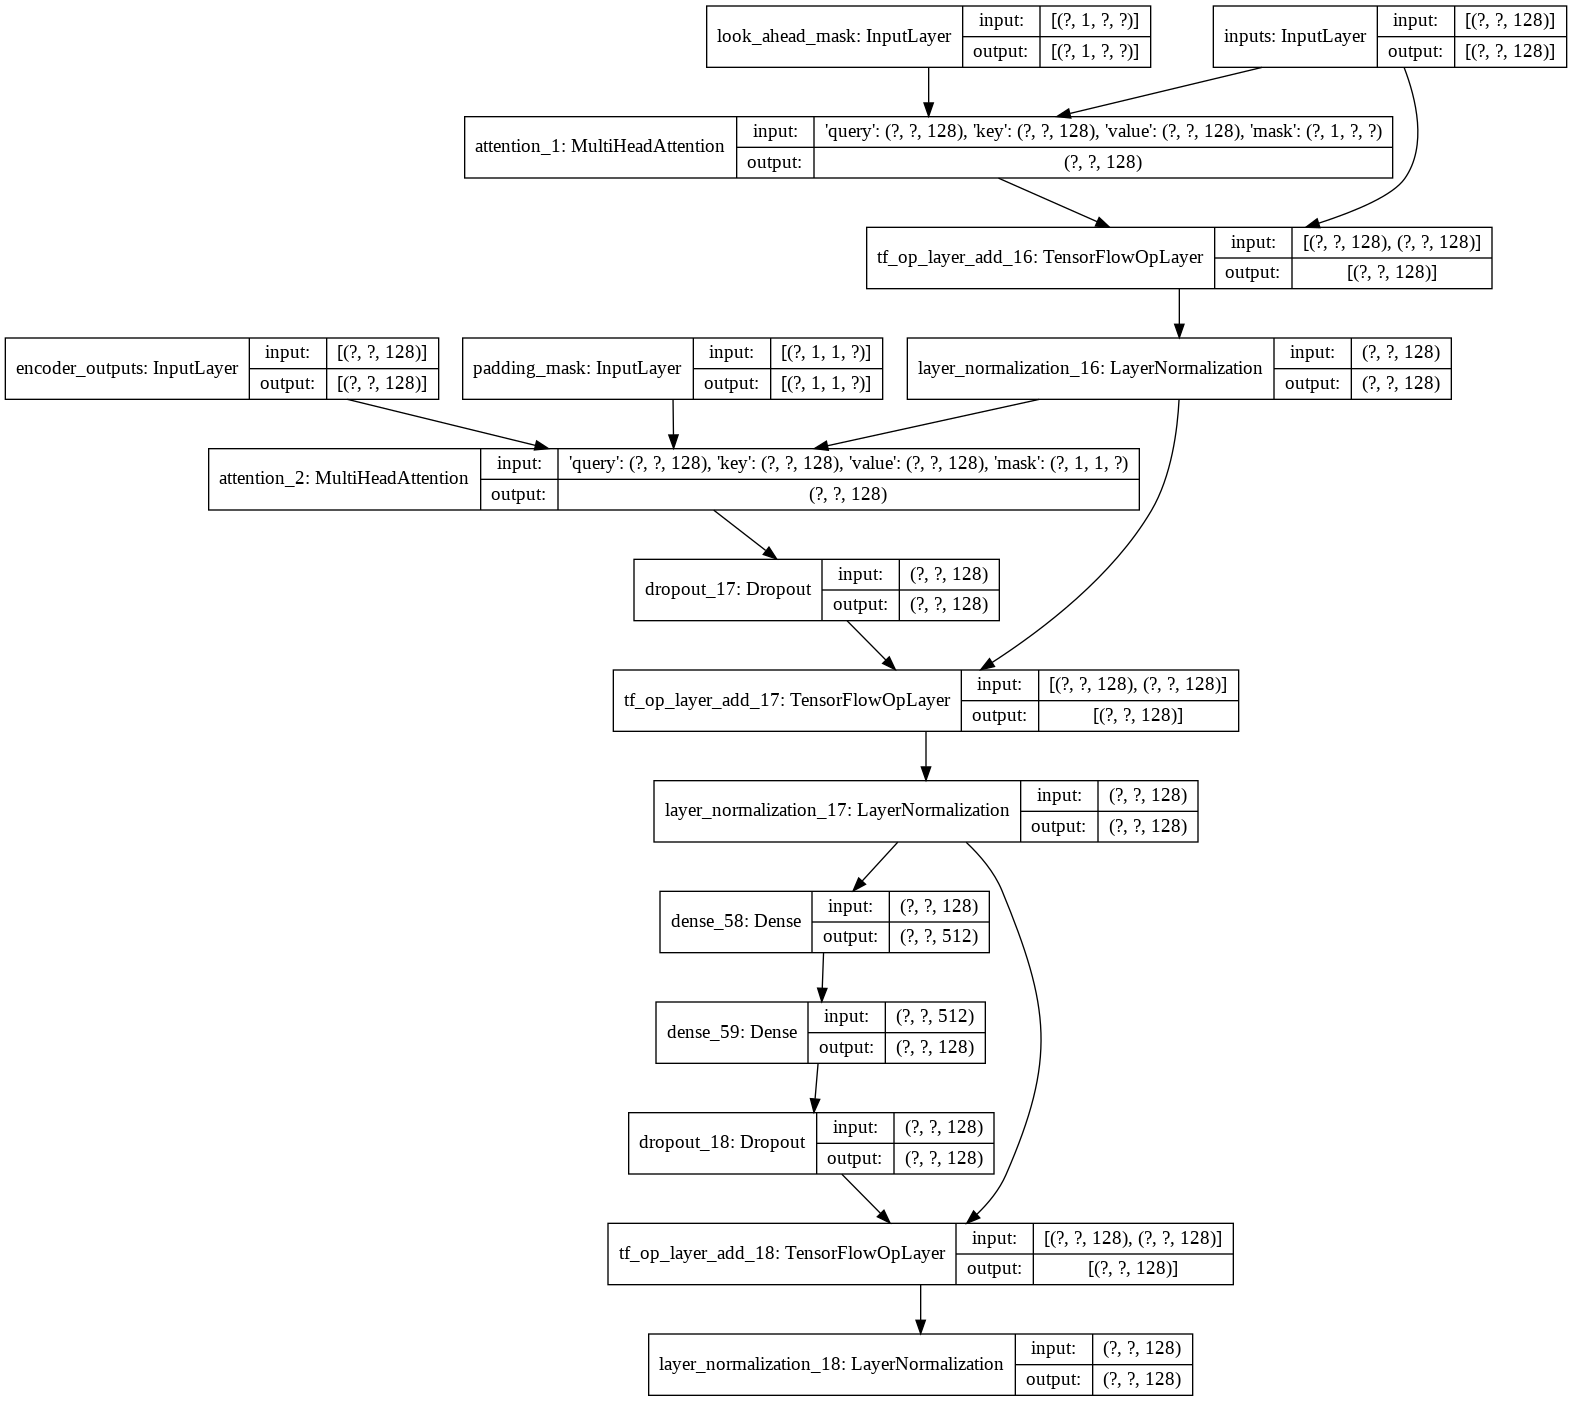

In [ ]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
  
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

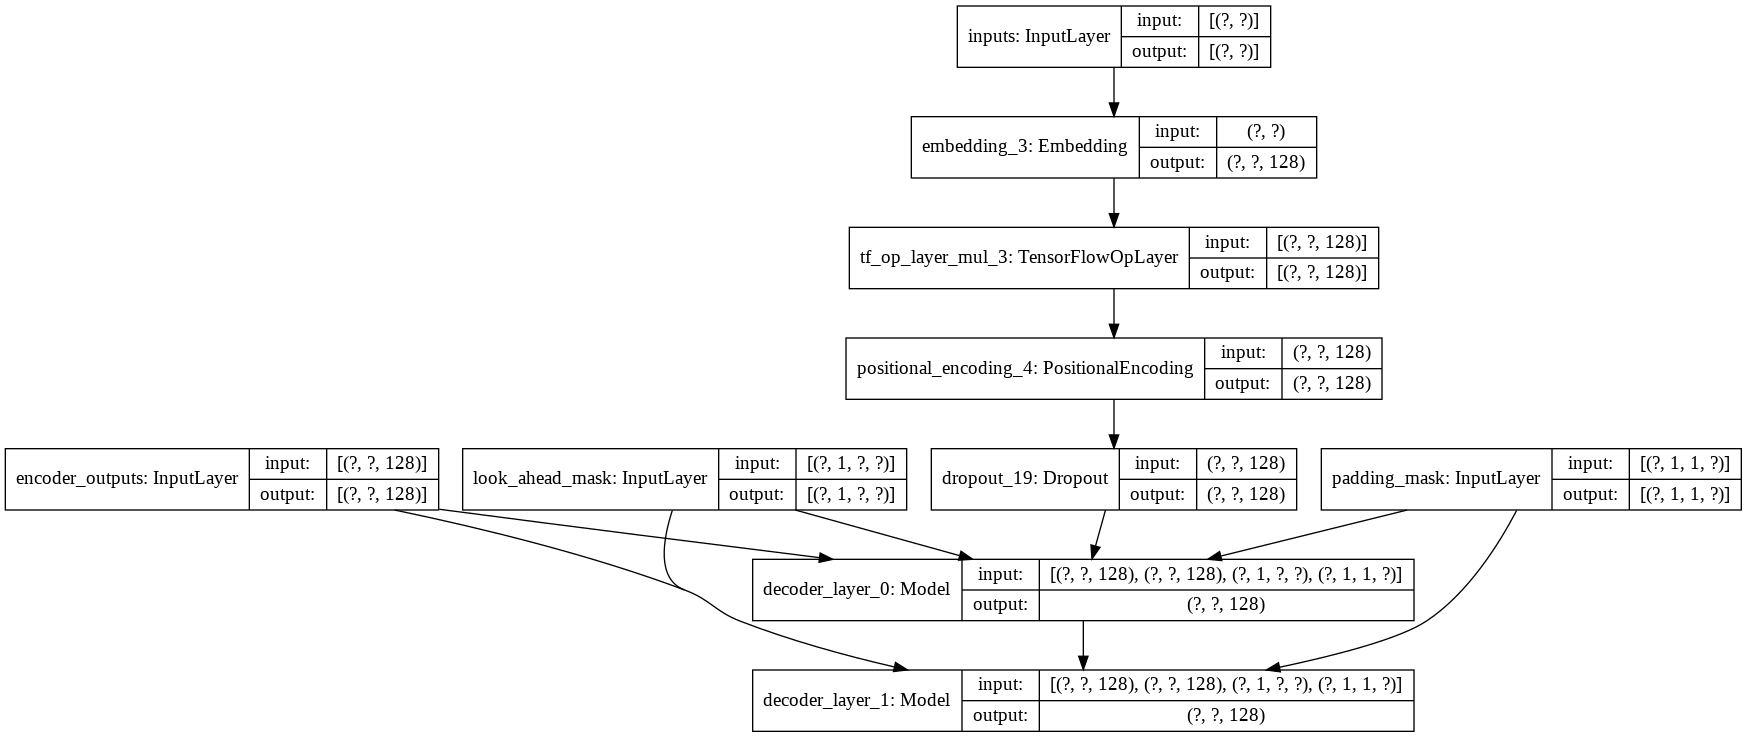

In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

sample_decoder = decoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)

The Transformer

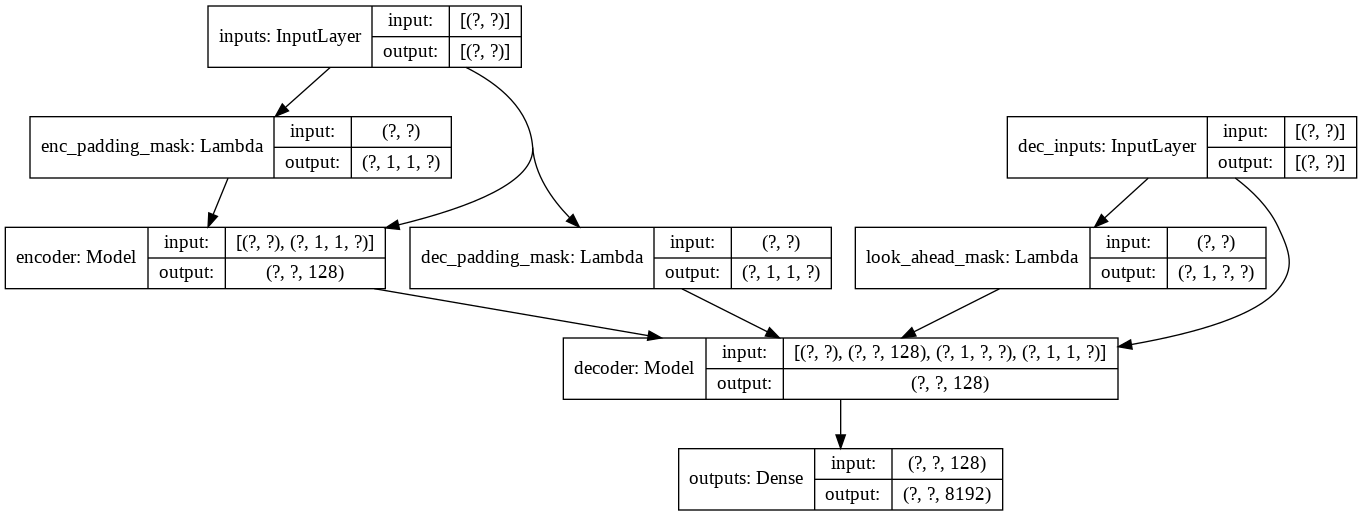

In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

sample_transformer = transformer(
    vocab_size=8192,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

Training Conversational Chatbots

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

Text(0.5, 0, 'Train Step')

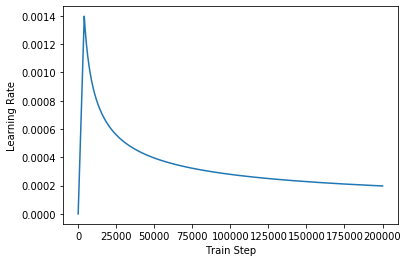

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

Compile the Model

In [ ]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Training the Model


In [ ]:
checkpoint_path = "/content/drive/My Drive/training_tt/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True,verbose=1)

EPOCHS = 100

model.fit(dataset, epochs=EPOCHS, callbacks=[cp_callback])

!ls {checkpoint_dir}

Train for 689 steps
Epoch 1/100
688/689 [============================>.] - ETA: 0s - loss: 2.1139 - accuracy: 0.0421
Epoch 00001: saving model to /content/drive/My Drive/training_tt/cp.ckpt
689/689 [==============================] - 81s 117ms/step - loss: 2.1130 - accuracy: 0.0421
Epoch 2/100
688/689 [============================>.] - ETA: 0s - loss: 1.5034 - accuracy: 0.0783
Epoch 00002: saving model to /content/drive/My Drive/training_tt/cp.ckpt
689/689 [==============================] - 73s 106ms/step - loss: 1.5035 - accuracy: 0.0784
Epoch 3/100
688/689 [============================>.] - ETA: 0s - loss: 1.3983 - accuracy: 0.0856
Epoch 00003: saving model to /content/drive/My Drive/training_tt/cp.ckpt
689/689 [==============================] - 74s 108ms/step - loss: 1.3982 - accuracy: 0.0856
Epoch 4/100
688/689 [============================>.] - ETA: 0s - loss: 1.3394 - accuracy: 0.0900
Epoch 00004: saving model to /content/drive/My Drive/training_tt/cp.ckpt
689/689 [===============

Evaluation and Prediction


In [ ]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
output = predict('Where have you been?')

output = predict("It's a trap")

In [ ]:
sentence = 'I am not crazy, my mother had me tested.'
for _ in range(5):
  sentence = predict(sentence)
  print('')